# Obtenção de curvas de bombas e ponto de operação utilizando Python

Passo 1 - Importar algumas bibliotecas - Pandas, numpy e matplotlib

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Passo 2 - Ler o arquivo contendo a curva da bomba, em formato excel

In [17]:
df = pd.read_excel('pump.xlsx')

Passo 3 - Como a vazão não está no SI, convém-se converter a mesma e criar uma coluna com a unidade adequada

In [18]:
df['Flow (m³/s)'] = df['Flow (l/s)'].apply(lambda x: 0.001*x)

Passo 4 - Remover a coluna sem a unidade no SI

In [19]:
df.drop('Flow (l/s)',inplace=True,axis=1)

In [22]:
df

,Pump Head (m),Flow (m³/s)
0,53.5,0.00
1,53.0,0.02
2,52.5,0.04
3,51.5,0.06
4,50.0,0.08
5,48.0,0.10
6,45.5,0.12
7,42.0,0.14
8,37.0,0.16


Passo 5 - Converter os dados em formato de array, para plotá-los

In [23]:
x = df['Flow (m³/s)'].values

In [24]:
y = df['Pump Head (m)'].values

Passo 6 - Realizar uma interpolação polinomial do segundo grau para esses pontos

In [44]:
p = np.polyfit(x,y,2)

[-748.10606061   22.61363636   53.08484848]


Passo 7 - Plotar os pontos e a curva obtida a partir do polinômio interpolador

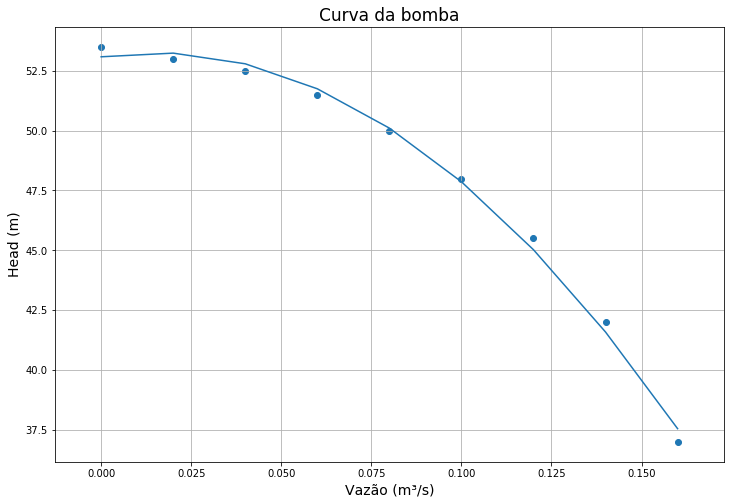

In [201]:
plt.figure(figsize=(12,8))
plt.grid(True)
plt.ylabel('Head (m)',size=14)
plt.xlabel('Vazão (m³/s)',size=14)
plt.title('Curva da bomba',size=17)
plt.scatter(x,y)
plt.plot(x,p[0]*x**2 + p[1]*x + p[2])

# Criando a curva de operação - equação de Bernoulli com fator de atrito

Passo 1 - Chamando as bibliotecas de resolução de equações não lineares e a biblioteca math

In [28]:
from scipy import optimize
from math import pi,log,sqrt

Passo 2 - Criando a função para o fator de atrito

In [12]:
def fator_atrito(f,ee,Re):
    y = 1/sqrt(f) + 2*log(((ee/3.7) + 2.51/(Re*sqrt(f))),10)
    return y

Passo 3 - Criando a função solver, contendo a equação de Bernoulli e repetindo várias vezes para obter o head em função da vazão. Em regime turbulento, adota-se o modelo de Colebrook para o cálculo do fator de atrito, que recai numa equação não linear, cuja raiz é obtida pelo método de Newton-Raphson.

In [200]:
def solve(visc,rho,L,z,D,Pe,Ps,ep,p):
    v = np.arange(0.01,15,0.01)
    h = np.empty(len(v))
    Q = np.empty(len(v))
    g = np.empty(len(v))
    k = np.zeros([len(v),3])
    for i in range(len(v)):
        Re = rho*v[i]*D/visc
        ed = ep/D
        if Re>4000:
            fator = optimize.newton(fator_atrito,64/Re,args=(ed,Re))
        else:
            fator = 64/Re
        h[i] = (Ps - Pe)/rho + 9.81*z + fator*L*(v[i]**2)/(2*D)
        Q[i] = v[i]*(pi*D**2)/4
        g[i] = p[0]*Q[i]**2 + p[1]*Q[i] + p[2]
        k[i,1] = abs(h[i]-g[i])
        k[i,0] = Q[i]
        k[i,2] = h[i]
    return Q,h,k

In [170]:
a = solve(1e-4,1e3,2,1.5,0.1,1e5,1.2e5,1e-5,p)

In [197]:
def operation(a):
    z = np.min(a[2][:,1])
    zz = np.where(a[2][:,1] == z)
    xx = a[2][zz][0][0]
    yy = a[2][zz][0][2]
    return xx,yy

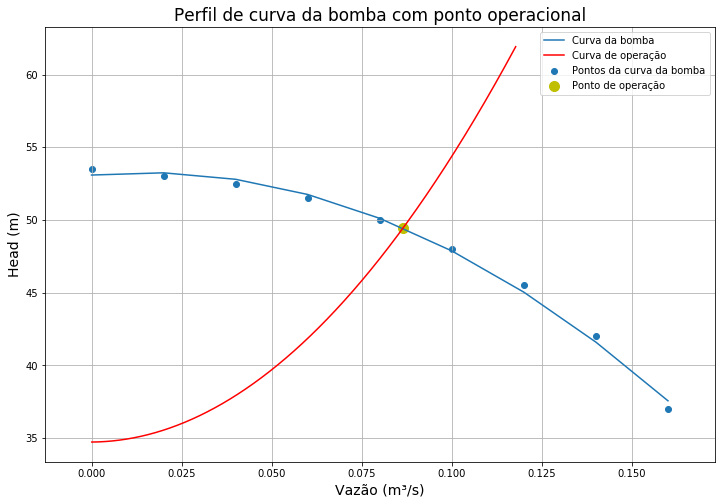

In [202]:
plt.figure(figsize=(12,8))
plt.grid(True)
plt.ylabel('Head (m)',size=14)
plt.xlabel('Vazão (m³/s)',size=14)
plt.title('Perfil de curva da bomba com ponto operacional',size=17)
plt.scatter(x,y)
g = p[0]*x**2 + p[1]*x + p[2]
plt.plot(x,g)
plt.plot(a[0],a[1],'r')
plt.scatter(operation(a)[0],operation(a)[1],c='y',alpha=1,s=100)
plt.legend(['Curva da bomba','Curva de operação','Pontos da curva da bomba','Ponto de operação'])

Conforme a curva, pode-se perceber que o ponto de operação da bomba se dá com uma vazão entre 75 e 100 L/s. Vazões acima do ponto de operação podem levar à cavitação da bomba

Definindo precisamente esse ponto de operação, em m³/s

In [199]:
operation(a)[0]

0.08647233779005906

Ou seja, o ponto de operação dessa bomba, nessas condições é de 86.47 L/s